## Importing libraries

In [70]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from tqdm.notebook import tqdm
from PIL import Image
from tensorflow.keras.utils import load_img
from keras import Input, Model, Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, MaxPool2D
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, SVR
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
from tensorflow.keras.regularizers import l2

In [2]:
base_dir = r"D:\Study\Level 3\First term\Selected 1\Project\Aligned&Cropped Faces\UTKFace"

## Fetures extracting from images' name

In [3]:
image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(base_dir)):
    image_path = os.path.join(base_dir, filename)
    temp = filename.split('_')
    age = temp[0]
    gender = temp[1]
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

  0%|          | 0/23708 [00:00<?, ?it/s]

## We can split the data into Classes

###### (1-10) CLASS 0  |  (10-20) CLASS 1  |  (20-30) CLASS 2  |  (30-40) CLASS 3  |  (40-50) CLASS 4  |  (50-60) CLASS 5  |  (60-70) CLASS 6  | 
###### (70-80) CLASS 7  |  (80-90) CLASS 8  |  (90-100) CLASS 9  |  (>100) CLASS 10

In [4]:
classes = []
for i in age_labels:
    i = int(i)
    if i <= 10:
        classes.append(0)
    elif (i>10) and (i<=20):
        classes.append(1)
    elif (i>20) and (i<=30):
        classes.append(2)
    elif (i>30) and (i<=40):
        classes.append(3)
    elif (i>40) and (i<=50):
        classes.append(4)
    elif (i>50) and (i<=60):
        classes.append(5)
    elif (i>60) and (i<=70):
        classes.append(6)
    elif (i>70) and (i<=80):
        classes.append(7)
    elif (i>80) and (i<=90):
        classes.append(8)
    elif (i>90) and (i<=100):
        classes.append(9)
    else:
        classes.append(10)

In [51]:
def get_age_group(y_group):
    y_group_pred = []
    for i in y_group:
        if i <0.5:
            y_group_pred.append(0)
        elif i < 1.5:
            y_group_pred.append(1)
        elif i < 2.5:
            y_group_pred.append(2)
        elif i < 3.5:
            y_group_pred.append(3)
        elif i < 4.5:
            y_group_pred.append(4)
        elif i < 5.5:
            y_group_pred.append(5)
        elif i < 6.5:
            y_group_pred.append(6)
        elif i < 7.5:
            y_group_pred.append(7)
        elif i < 8.5:
            y_group_pred.append(8)
        elif i < 9.5:
            y_group_pred.append(9)
        else:
            y_group_pred.append(10)
    return y_group_pred

In [6]:
def get_gender(y_gender):
    y_gender_pred = []
    for i in y_gender:
        if i <0.5:
            y_gender_pred.append(0)
        else:
            y_gender_pred.append(1)
    return y_gender_pred

In [7]:
df = pd.DataFrame()
df['image'], df['group'], df['age'], df['gender'] = image_paths, classes, age_labels, gender_labels
df.sample(n=3)

,image,group,age,gender
21422,D:\Study\Level 3\First term\Selected 1\Project...,6,67,0
14979,D:\Study\Level 3\First term\Selected 1\Project...,3,39,1
10145,D:\Study\Level 3\First term\Selected 1\Project...,0,2,0


In [8]:
df['age'] = pd.to_numeric(df['age'])
df['gender'] = pd.to_numeric(df['gender'])

In [9]:
gender_dict = {0:'Male', 1:'Female'}

## Plotting a sample

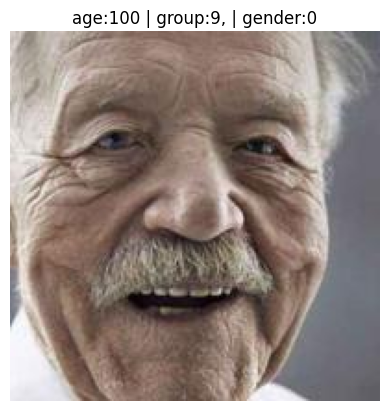

In [10]:
img = Image.open(df['image'][0])
plt.axis("off")
plt.title(f"age:{df['age'][0]} | group:{df['group'][0]}, | gender:{df['gender'][0]}")
plt.imshow(img)

## Exploratory Analysis

C:\Users\youse\AppData\Local\Temp\ipykernel_13896\4278248145.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['group'])


<AxesSubplot: xlabel='group', ylabel='Density'>

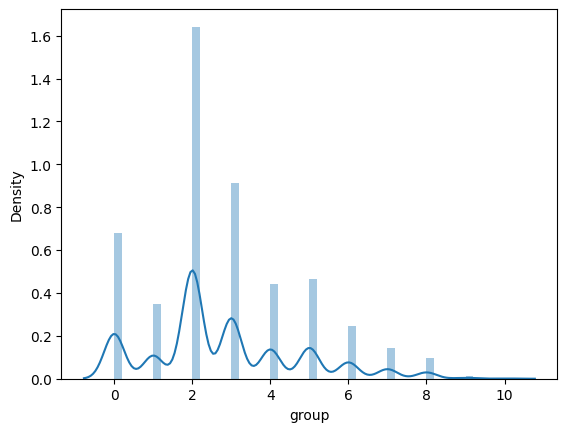

In [11]:
sns.distplot(df['group'])

<AxesSubplot: xlabel='gender', ylabel='count'>

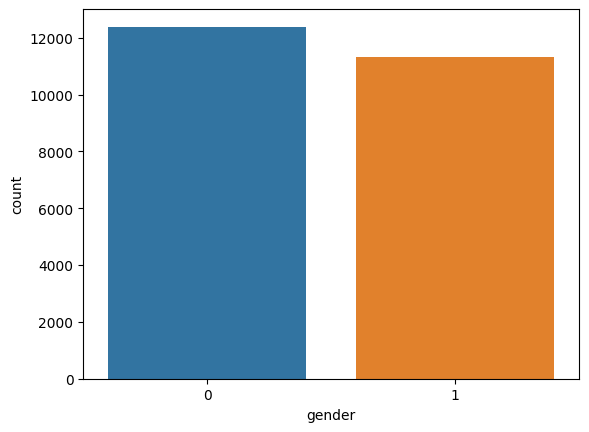

In [12]:
sns.countplot(df, x='gender')

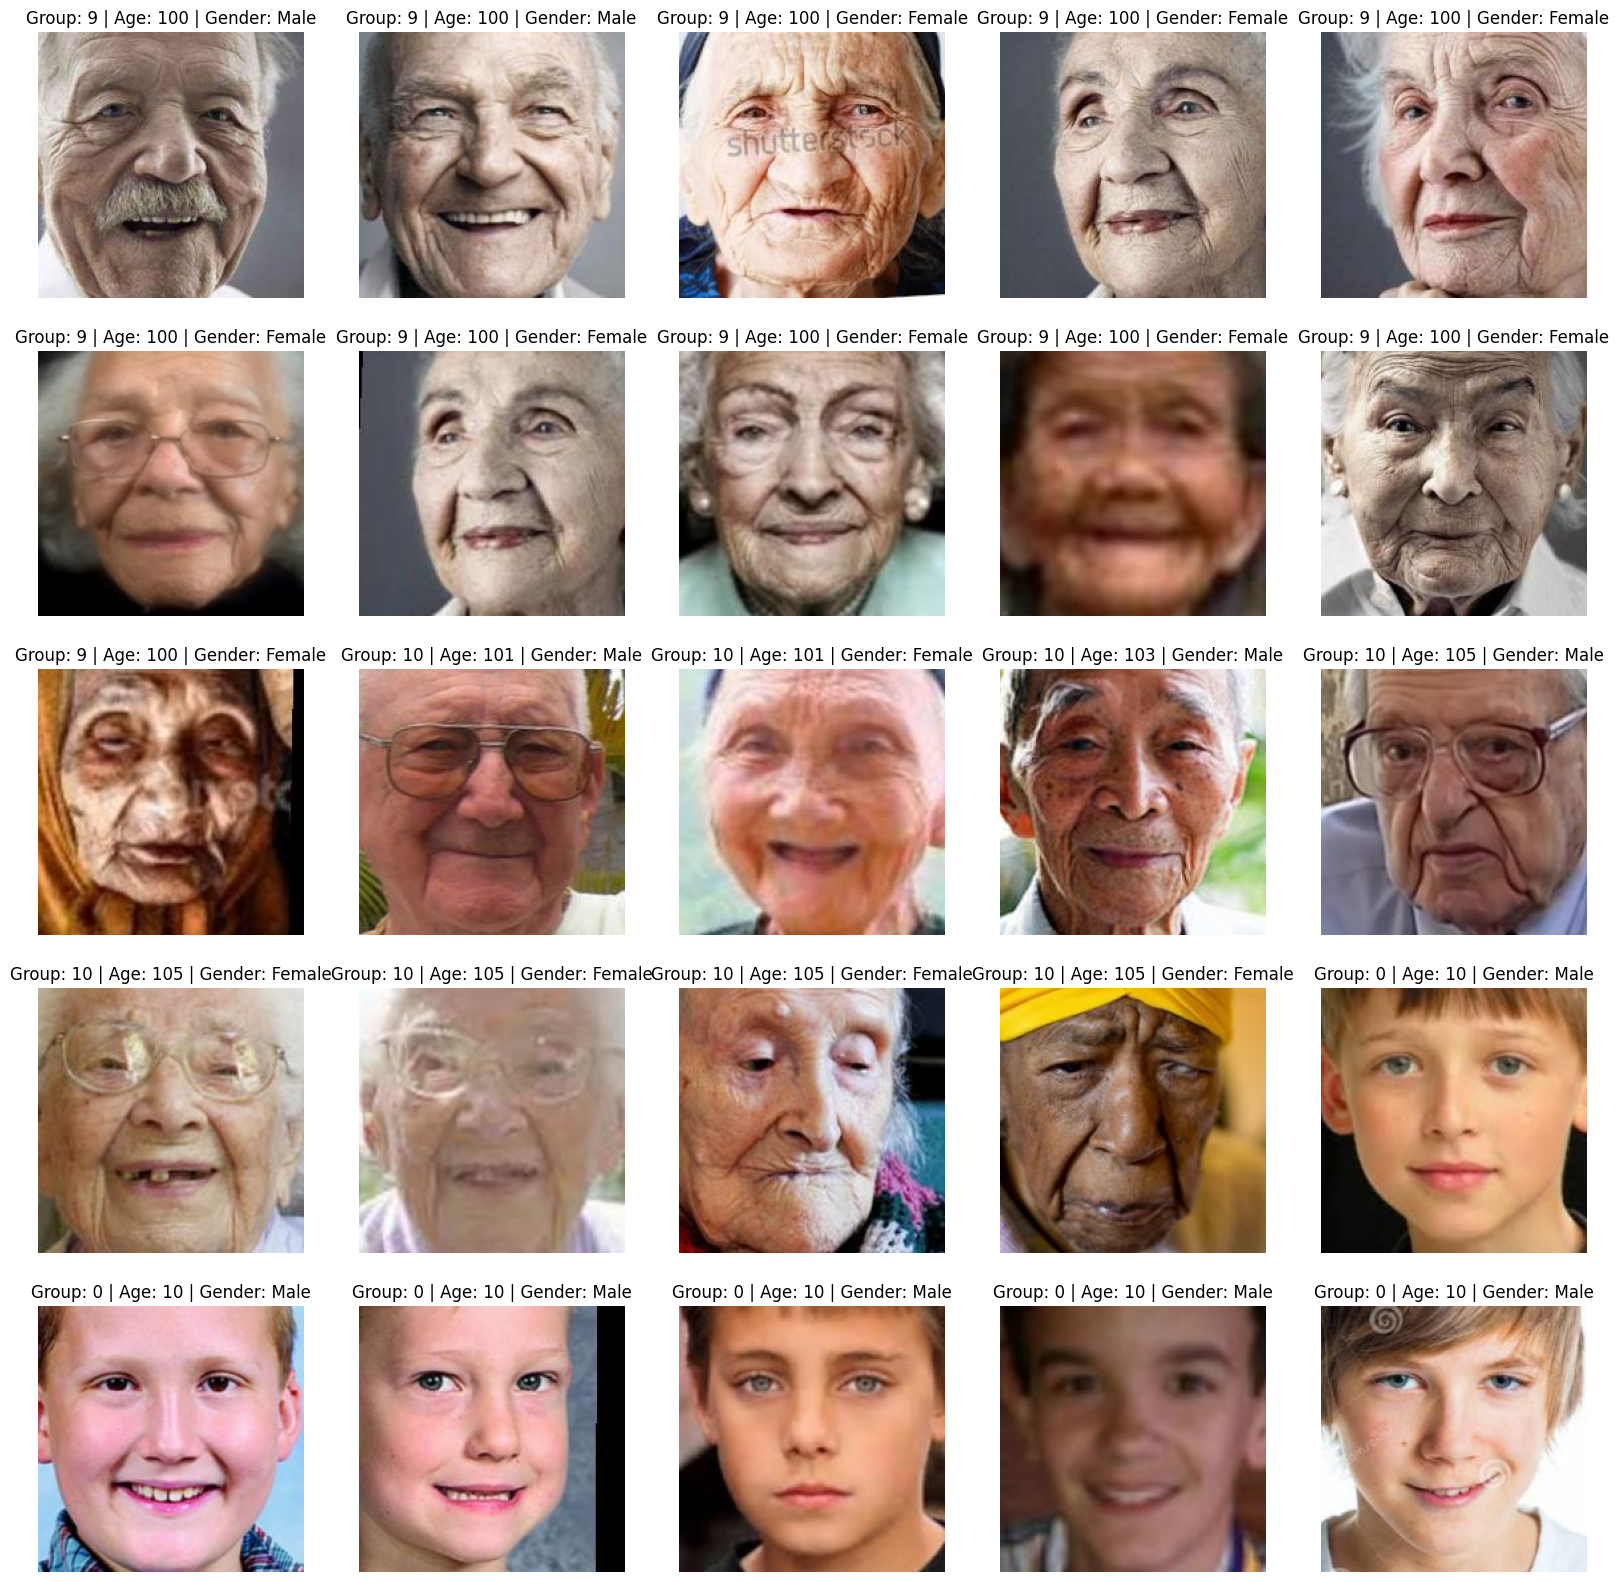

In [13]:
plt.figure(figsize=(20,20))
files = df.iloc[0:25]
for index, file, group, age, gender in files.itertuples():
    plt.subplot(5,5,index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Group: {group} | Age: {age} | Gender: {gender_dict[gender]}")
    plt.axis('off')

## Function to extract features in images (image to data)

In [14]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, color_mode = "grayscale")
        img = img.resize((64,64), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)
    features = np.array(features)
    return features

In [15]:
X = extract_features(df['image'])

  0%|          | 0/23708 [00:00<?, ?it/s]

C:\Users\youse\AppData\Local\Temp\ipykernel_13896\2493968180.py:5: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = img.resize((64,64), Image.ANTIALIAS)


In [16]:
X.shape

(23708, 64, 64)

In [17]:
X = X/255.0

In [18]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])
y_age_group = np.array(df['group'])

### Spliting train and test module

In [19]:
y = df[['group', 'age', 'gender']]

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
y_train['group']

5096     2
19586    5
9835     2
13631    3
9807     2
        ..
21575    6
5390     2
860      1
15795    3
23654    0
Name: group, Length: 18966, dtype: int64

# Neural Network model

In [36]:
inputs = Input(shape=(64,64,1))
conv1 = Conv2D(32, kernel_size=(3, 3),activation='relu')(inputs)
conv2 = Conv2D(64, kernel_size=(3, 3),activation='relu')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(128, kernel_size=(3, 3),activation='relu')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv3)
x = Dropout(0.25)(pool2)
flat = Flatten()(x)

dropout = Dropout(0.5)
age_model = Dense(128, activation='relu')(flat)
age_model = dropout(age_model)
age_model = Dense(64, activation='relu')(age_model)
age_model = dropout(age_model)
age_model = Dense(32, activation='relu')(age_model)
age_model = dropout(age_model)
age_model = Dense(16, activation='relu')(age_model)
age_model = dropout(age_model)
age_model = Dense(8, activation='relu')(age_model)
age_model = dropout(age_model)
age_model = Dense(1, activation='relu')(age_model)

dropout = Dropout(0.5)
gender_model = Dense(128, activation='relu')(flat)
gender_model = dropout(gender_model)
gender_model = Dense(64, activation='relu')(gender_model)
gender_model = dropout(gender_model)
gender_model = Dense(32, activation='relu')(gender_model)
gender_model = dropout(gender_model)
gender_model = Dense(16, activation='relu')(gender_model)
gender_model = dropout(gender_model)
gender_model = Dense(8, activation='relu')(gender_model)
gender_model = dropout(gender_model)
gender_model = Dense(1, activation='sigmoid')(gender_model)

model = Model(inputs=inputs, outputs=[age_model,gender_model])
model.compile(optimizer = 'adam', loss =['mse','binary_crossentropy'],metrics=['accuracy'])

In [39]:
h = model.fit(X_train,[y_train['group'],y_train['gender']],validation_data=(X_test,[y_test['group'],y_test['gender']]),epochs = 25, batch_size=128)

Epoch 1/25
149/149 [==============================] - 286s 2s/step - loss: 7.0115 - dense_55_loss: 6.4245 - dense_61_loss: 0.5871 - dense_55_accuracy: 0.1055 - dense_61_accuracy: 0.7289 - val_loss: 5.4103 - val_dense_55_loss: 4.9134 - val_dense_61_loss: 0.4968 - val_dense_55_accuracy: 0.0673 - val_dense_61_accuracy: 0.8098
Epoch 2/25
149/149 [==============================] - 301s 2s/step - loss: 6.4228 - dense_55_loss: 5.8837 - dense_61_loss: 0.5392 - dense_55_accuracy: 0.0752 - dense_61_accuracy: 0.7670 - val_loss: 4.7284 - val_dense_55_loss: 4.2952 - val_dense_61_loss: 0.4332 - val_dense_55_accuracy: 0.0673 - val_dense_61_accuracy: 0.8406
Epoch 3/25
149/149 [==============================] - 265s 2s/step - loss: 5.9803 - dense_55_loss: 5.4704 - dense_61_loss: 0.5099 - dense_55_accuracy: 0.0827 - dense_61_accuracy: 0.7836 - val_loss: 4.6111 - val_dense_55_loss: 4.2030 - val_dense_61_loss: 0.4081 - val_dense_55_accuracy: 0.0673 - val_dense_61_accuracy: 0.8473
Epoch 4/25
149/149 [=====

model.save('model.h5')

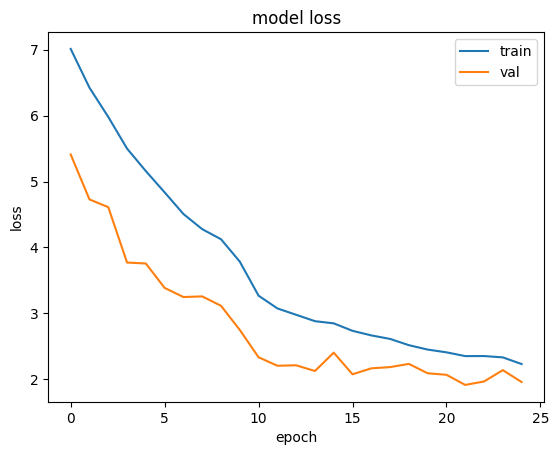

In [40]:
history = h
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

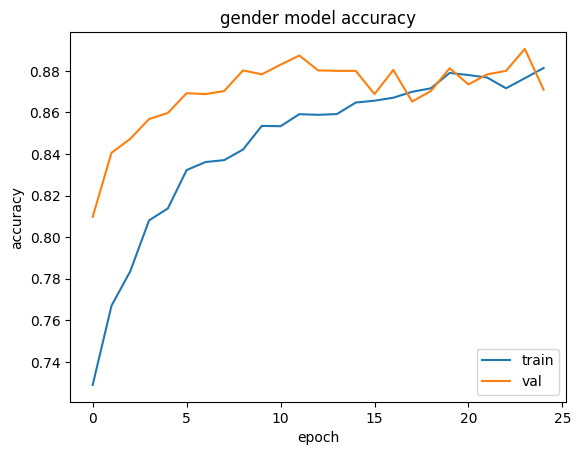

In [43]:
plt.plot(history.history['dense_61_accuracy'])
plt.plot(history.history['val_dense_61_accuracy'])
plt.title('gender model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

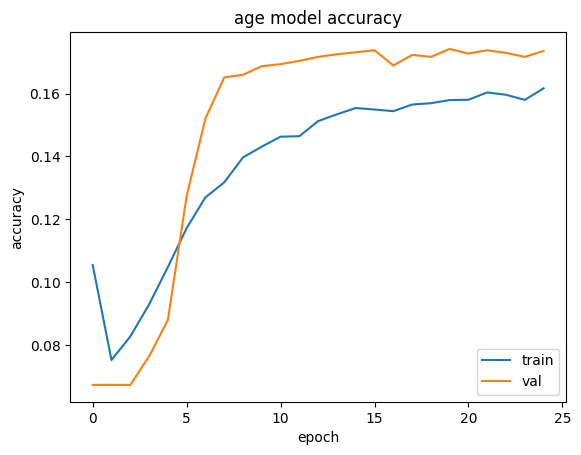

In [44]:
plt.plot(history.history['dense_55_accuracy'])
plt.plot(history.history['val_dense_55_accuracy'])
plt.title('age model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

In [45]:
y_pred = model.predict(X_test)

149/149 [==============================] - 12s 77ms/step


In [46]:
len(y_pred[0])

4742

In [52]:
y_group_pred = get_age_group(y_pred[0])

<AxesSubplot: >

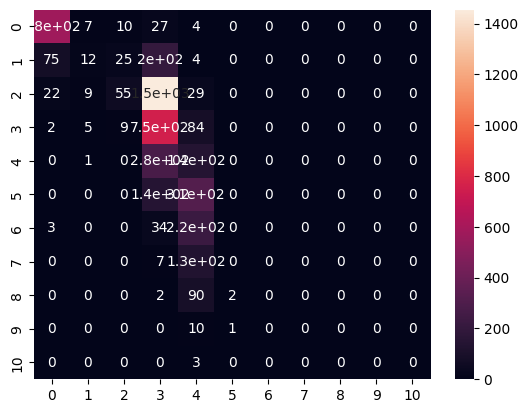

In [53]:
#confusion matrix for age group prediction
cm = confusion_matrix(y_test['group'], y_group_pred)
sns.heatmap(cm, annot=True)

In [56]:
y_gender_pred = get_gender(y_pred[1])

<AxesSubplot: >

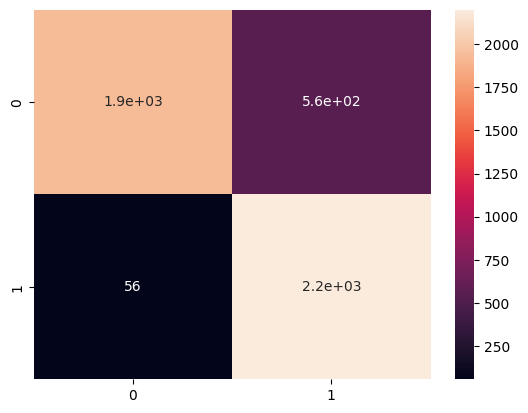

In [57]:
#confusion matrix for gender prediction
cm = confusion_matrix(y_test['gender'], y_gender_pred)
sns.heatmap(cm, annot=True)

In [58]:
roc = roc_curve(y_test['gender'], y_pred[1])

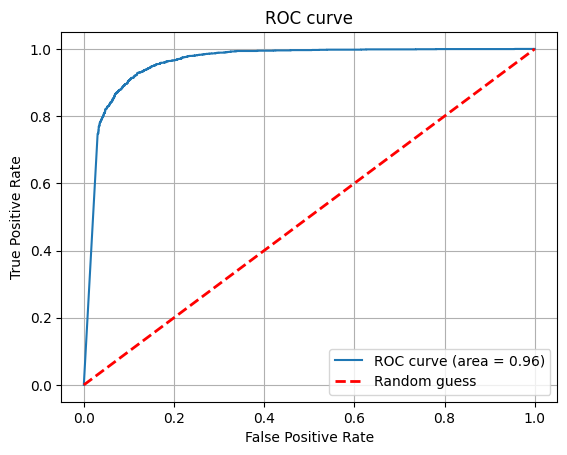

In [59]:
auc = auc(roc[0], roc[1])
plt.plot(roc[0], roc[1], label='ROC curve (area = %.2f)' %auc)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random guess')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.legend()
plt.show()

# Support Vector Machine

In [60]:
gender_model = Sequential()
gender_model.add(Conv2D(filters = 32, padding = "same",activation = "relu",kernel_size=3, strides = 2,input_shape=(64,64,1)))
gender_model.add(MaxPool2D(pool_size=(2,2),strides = 2))

gender_model.add(Conv2D(filters = 32, padding = "same",activation = "relu",kernel_size=3))
gender_model.add(MaxPool2D(pool_size=(2,2),strides = 2))

gender_model.add(Flatten())
gender_model.add(Dense(128,activation="relu"))

#Output layer
gender_model.add(Dense(1,kernel_regularizer=l2(0.01),activation = "linear"))

gender_model.compile(optimizer = 'adam', loss = "hinge", metrics = ['accuracy'])

In [61]:
gender_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 32, 32, 32)        320       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 8, 8, 32)         0         
 g2D)                                                            
                                                                 
 flatten_6 (Flatten)         (None, 2048)              0         
                                                                 
 dense_62 (Dense)            (None, 128)               2

In [62]:
history_svm_gender = gender_model.fit(X_train, y_train['gender'], validation_data=(X_test,y_test['gender']), epochs=15)

Epoch 1/15
593/593 [==============================] - 16s 26ms/step - loss: 0.5257 - accuracy: 0.7577 - val_loss: 0.3913 - val_accuracy: 0.8237
Epoch 2/15
593/593 [==============================] - 18s 30ms/step - loss: 0.3771 - accuracy: 0.8268 - val_loss: 0.3554 - val_accuracy: 0.8290
Epoch 3/15
593/593 [==============================] - 18s 30ms/step - loss: 0.3363 - accuracy: 0.8464 - val_loss: 0.3425 - val_accuracy: 0.8372
Epoch 4/15
593/593 [==============================] - 17s 29ms/step - loss: 0.3122 - accuracy: 0.8589 - val_loss: 0.3543 - val_accuracy: 0.8172
Epoch 5/15
593/593 [==============================] - 18s 30ms/step - loss: 0.2924 - accuracy: 0.8686 - val_loss: 0.3068 - val_accuracy: 0.8775
Epoch 6/15
593/593 [==============================] - 18s 30ms/step - loss: 0.2715 - accuracy: 0.8807 - val_loss: 0.2971 - val_accuracy: 0.8562
Epoch 7/15
593/593 [==============================] - 18s 30ms/step - loss: 0.2611 - accuracy: 0.8837 - val_loss: 0.2973 - val_accuracy:

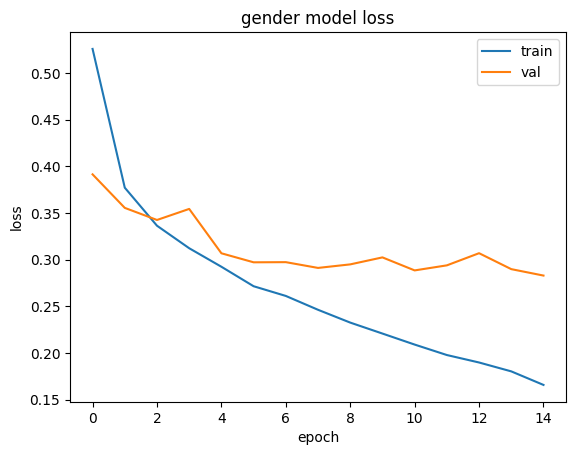

In [63]:
plt.plot(history_svm_gender.history['loss'])
plt.plot(history_svm_gender.history['val_loss'])
plt.title('gender model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

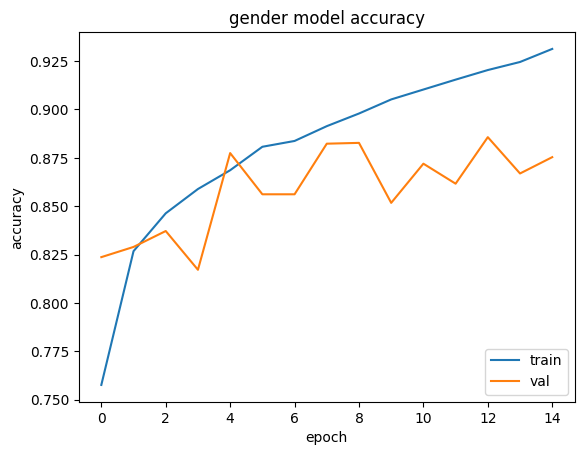

In [64]:
plt.plot(history_svm_gender.history['accuracy'])
plt.plot(history_svm_gender.history['val_accuracy'])
plt.title('gender model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

149/149 [==============================] - 1s 7ms/step


<AxesSubplot: >

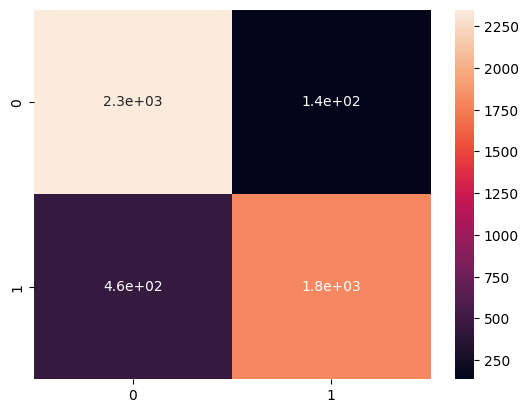

In [65]:
y_pred = gender_model.predict(X_test)
y_pred_fun = get_gender(y_pred)

#confusion matrix for gender prediction
cm = confusion_matrix(y_test['gender'], y_pred_fun)
sns.heatmap(cm, annot=True)

In [66]:
roc = roc_curve(y_test['gender'], y_pred)

In [68]:
roc[0]

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.02414487e-04,
       4.02414487e-04, 8.04828974e-04, 8.04828974e-04, 1.20724346e-03,
       1.20724346e-03, 1.20724346e-03, 1.20724346e-03, 1.60965795e-03,
       1.60965795e-03, 2.01207243e-03, 2.01207243e-03, 2.41448692e-03,
       2.41448692e-03, 2.41448692e-03, 2.41448692e-03, 2.81690141e-03,
       2.81690141e-03, 3.21931590e-03, 3.21931590e-03, 3.62173038e-03,
       3.62173038e-03, 3.62173038e-03, 3.62173038e-03, 4.42655936e-03,
       4.42655936e-03, 4.82897384e-03, 4.82897384e-03, 5.23138833e-03,
       5.23138833e-03, 5.63380282e-03, 5.63380282e-03, 6.03621730e-03,
       6.03621730e-03, 6.43863179e-03, 6.43863179e-03, 7.24346076e-03,
       7.24346076e-03, 7.64587525e-03, 7.64587525e-03, 8.04828974e-03,
       8.04828974e-03, 8.45070423e-03, 8.45070423e-03, 8.85311871e-03,
       8.85311871e-03, 9.25553320e-03, 9.25553320e-03, 9.65794769e-03,
      

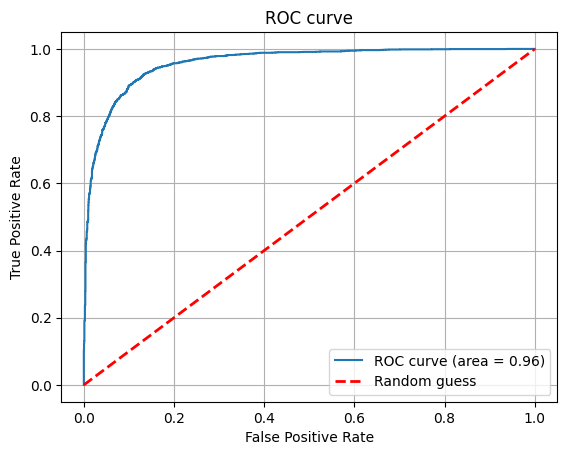

In [71]:
auc = metrics.auc(roc[0], roc[1])
plt.plot(roc[0], roc[1], label='ROC curve (area = %.2f)' %auc)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random guess')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.legend()
plt.show()